In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\s_sad\Final Project\twitter_sentiment2.csv") # importing clean data

In [3]:
df.isnull().sum() # checking and dropping nan values

tweet              28
date                0
brand               0
sentiment_score     0
sentiment           0
dtype: int64

In [4]:
df =df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41714 entries, 0 to 41741
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet            41714 non-null  object 
 1   date             41714 non-null  object 
 2   brand            41714 non-null  object 
 3   sentiment_score  41714 non-null  float64
 4   sentiment        41714 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


In [5]:
df

,tweet,date,brand,sentiment_score,sentiment
0,either way think youre vastly overestimate tes...,2022-10-01,tesla,0.6355,Positive
1,find problematic,2022-10-01,tesla,-0.4404,Negative
2,sure tesla ai robot less let end video,2022-10-01,tesla,0.3182,Positive
3,may well youd hard press see consequence base ...,2022-10-01,tesla,0.1779,Positive
4,elon musk claim tesla cybertruck truck boat he...,2022-10-01,tesla,0.0000,Neutral
...,...,...,...,...,...
41737,totally agree though dont think amount marketi...,2022-12-31,bmw,0.6697,Positive
41738,thedr tesla lose billion market capitalization...,2022-12-31,tesla,-0.4019,Negative
41739,barrons top weekend stock pick tesla bed bath ...,2022-12-31,tesla,0.2023,Positive
41740,doge certainly seem way certainly respect musk...,2022-12-31,tesla,0.9153,Positive


In [6]:
df['sentiment'] = [0 if b=='Negative' else 1 if b== 'Neutral' else 2 for b in df.sentiment]
df['sentiment'].value_counts()

2    19106
1    12016
0    10592
Name: sentiment, dtype: int64

### Train, Test and Validation Split 

In [7]:
def train_test_validation(dataset):
    X = dataset.drop('sentiment', axis=1)
    y = dataset['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    train = pd.concat([X_train,y_train], axis=1)
    validation = pd.concat([X_validation, y_validation], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    return train, test, validation

In [8]:
train, test, validation = train_test_validation(df)

In [9]:
train.to_csv("train.csv")
validation.to_csv("validation.csv")
test.to_csv("test.csv")

In [10]:
X_train = train["tweet"]
y_train = train["sentiment"]

In [11]:
X_test = test["tweet"]
y_test = test["sentiment"]

In [12]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [13]:
y_test.value_counts()

2    6261
1    3975
0    3530
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

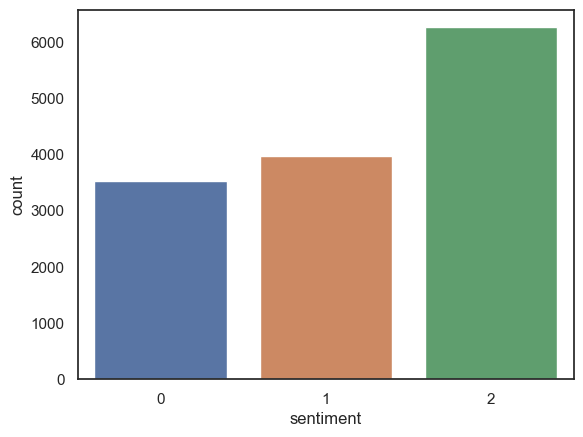

In [14]:
sns.countplot(y_test)

In [15]:
X_train.shape

(20961, 2985)

In [16]:
X_test.shape

(13766, 2985)

### Baseline Models 

In [17]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=42)
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)
nb = MultinomialNB()
mlp = MLPClassifier(random_state=42)
lr = LogisticRegression(random_state = 42)

clfs = {
    "Random Forest": rf,
    "Gradient Boosting":gb,
    "AdaBoost": ada,
    "LightGBM": lgb,
    "XGBoost": xgb,
    "Decision Tree":dt,
    "Support Vector Machine":svc,
    "Naive Bayes": nb,
    "Multilayer Perceptron":mlp,
    "Logistic Regression": lr
}

    

train_score = []
test_score = []
F1_Macro = []
Precision = []
Recall = []
Fbeta_half = []
cv_results = []


for name,clf in tqdm(clfs.items()):
    clf.fit(X_train, y_train)
    y_predict_train = clf.predict(X_train)
    y_predict_test = clf.predict(X_test)
    train_score.append(accuracy_score(y_train, y_predict_train))
    test_score.append(accuracy_score(y_test, y_predict_test))
    F1_Macro.append(f1_score(y_test,y_predict_test, average = 'macro'))
    Precision.append(precision_score(y_test,y_predict_test, average = 'macro'))    
    Recall.append(recall_score(y_test,y_predict_test, average = 'macro'))
    Fbeta_half.append(fbeta_score(y_test,y_predict_test, beta = 0.5, average = "macro"))
    cv_results.append(np.mean(cross_val_score(clf,X_train,y_train, scoring = "accuracy", cv = 10, n_jobs =4)))

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
models_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Training":train_score,
                         "Accuracy test": test_score, "F1 Macro": F1_Macro, "Precision": Precision,
                         "Recall": Recall, "Fbeta_half": Fbeta_half, "Cross Validation": cv_results}).sort_values('F1 Macro',ascending=False)
models_df

,Models,Accuracy Training,Accuracy test,F1 Macro,Precision,Recall,Fbeta_half,Cross Validation
8,Multilayer Perceptron,0.998807,0.838515,0.829478,0.829374,0.830305,0.829329,0.828157
6,Support Vector Machine,0.971375,0.834738,0.820620,0.834795,0.818516,0.827442,0.833023
9,Logistic Regression,0.891704,0.833575,0.820335,0.830631,0.818522,0.825366,0.828586
3,LightGBM,0.870808,0.835246,0.819968,0.832562,0.823994,0.825401,0.826248
4,XGBoost,0.848051,0.788028,0.768134,0.795108,0.770087,0.780034,0.787605
0,Random Forest,0.998807,0.780110,0.752642,0.788898,0.753499,0.768215,0.779018
5,Decision Tree,0.998807,0.698460,0.680597,0.679717,0.684147,0.679755,0.685892
1,Gradient Boosting,0.710844,0.691777,0.654766,0.726693,0.652781,0.683434,0.691617
7,Naive Bayes,0.742474,0.686547,0.653633,0.754386,0.631738,0.701543,0.681408
2,AdaBoost,0.659988,0.663228,0.629671,0.691253,0.642527,0.653252,0.650922


In [19]:
models_df.to_csv("models_df")

In [20]:
kfold = StratifiedKFold(n_splits=10)

### Hyperparameter Tunning on 4- best models

### SVC 

In [21]:
X_val = validation["tweet"]
y_val = validation["sentiment"]
X_val = vectorizer.transform(X_val)

In [22]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.498 total time= 1.2min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.490 total time= 1.2min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.498 total time= 1.2min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time= 1.1min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.502 total time=  50.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.462 total time=  50.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.461 total time=  51.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.461 total time=  53.7s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.464 total time=  56.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.463 total time=  56.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.458 total time=  58.6s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.828 total time= 1.6min
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.835 total time= 1.6min
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.831 total time= 1.6min
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.834 total time= 1.6min
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.836 total time=  51.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.828 total time=  48.8s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.824 total time=  49.9s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.818 total time=  49.3s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.826 total time=  49.8s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.826 total time=  31.9s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.816 total time=  32.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.827 total time=  31.8s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [23]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)


In [24]:
grid_predictions = grid.predict(X_val)
# print classification report
print(classification_report(y_val, grid_predictions))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1710
           1       0.85      0.97      0.91      2023
           2       0.89      0.87      0.88      3254

    accuracy                           0.86      6987
   macro avg       0.85      0.85      0.85      6987
weighted avg       0.86      0.86      0.86      6987



In [25]:
grid_predictions_train = grid.predict(X_train)  
print(accuracy_score(y_train, grid_predictions_train))
print(accuracy_score(y_val, grid_predictions))

0.9267687610323935
0.8621726062687849


## lgbm Hyperparameter

In [26]:
lgbmc = LGBMClassifier(objective = "multiclass", class_weight = 'balanced')

In [27]:
lgbm_params = {"n_estimators":[50,100,200,300],
               "learning_rate":[0.01,0.05,0.1,0.3],
               "num_leaves": [20,50,80,100]
               #"objective": [multiclass_ova]
              }
grid_search = GridSearchCV(estimator = lgbmc, param_grid = lgbm_params, n_jobs = 1, cv = 5, scoring = "roc_auc") 
grid_result = grid_search.fit(X_train,y_train)

In [28]:
# print best parameter after tuning
print(grid_search.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_search.best_estimator_)
grid_predictions = grid_search.predict(X_val)
# print classification report
print(classification_report(y_val, grid_predictions))
grid_predictions_train = grid_search.predict(X_train)  
print(accuracy_score(y_train, grid_predictions_train))
print(accuracy_score(y_val, grid_predictions))

{'learning_rate': 0.01, 'n_estimators': 50, 'num_leaves': 20}
LGBMClassifier(class_weight='balanced', learning_rate=0.01, n_estimators=50,
               num_leaves=20, objective='multiclass')
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      1710
           1       0.55      0.88      0.68      2023
           2       0.85      0.52      0.64      3254

    accuracy                           0.62      6987
   macro avg       0.63      0.64      0.61      6987
weighted avg       0.67      0.62      0.62      6987

0.632174037498211
0.6212966938600257


# XGBOOSt

In [29]:
xgboost = XGBClassifier()

In [30]:
# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    "objective" :["multi:softmax"],
    #"n_estimators" :[50,100,200,300],
    #"learning_rate":[0.01,0.05,0.1,0.3],
     #"num_leaves": [20,50,80,100]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [31]:
# Define grid search
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# Print grid search summary
grid_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is nan
The best hyperparameters are {'colsample_bytree': 0.3, 'objective': 'multi:softmax', 'reg_alpha': 0, 'reg_lambda': 0}


In [32]:
grid_predictions = grid_result.predict(X_val)
# print classification report
print(classification_report(y_val, grid_predictions))
grid_predictions_train = grid_result.predict(X_train)  
print(accuracy_score(y_train, grid_predictions_train))
print(accuracy_score(y_val, grid_predictions))

              precision    recall  f1-score   support

           0       0.84      0.55      0.67      1710
           1       0.75      0.94      0.83      2023
           2       0.83      0.84      0.83      3254

    accuracy                           0.80      6987
   macro avg       0.81      0.78      0.78      6987
weighted avg       0.81      0.80      0.79      6987

0.863031343924431
0.8003434950622584


In [33]:
mlp = MLPClassifier()

In [34]:
# defining parameter range
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# fitting the model for grid search
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [35]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.817 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.765 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.813 (+/-0.006) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.764 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.815 (+/-0.005) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.770 (+/-0.005) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'

In [36]:
val_predictions =clf.predict(X_val)
# print classification report
print(classification_report(y_val,val_predictions))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1710
           1       0.85      0.94      0.89      2023
           2       0.89      0.87      0.88      3254

    accuracy                           0.86      6987
   macro avg       0.84      0.85      0.84      6987
weighted avg       0.85      0.86      0.85      6987



## Logistic Regression

In [37]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [38]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.849454 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.817051 (0.007483) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.829154 (0.007612) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.840189 (0.006868) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.841673 (0.007012) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.842341 (0.006608) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.849454 (0.006920) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.827379 (0.008416) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.827270 (0.008432) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.815753 (0.008199) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.717442 (0.008709) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.717456 (0.008699) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.674543 (0.008202) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.471409 (0.002321) with